# Likelihood curves vs parameters


This notebook explores how the likelihood returned by the Kalman filter varies with respect to the choice of model parameters 


---

### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import json 
import pandas as pd 
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

### Define some functions 

Now to start, lets make a function that creates some synthetic data for a particular strain, measurement noise and noise seed AND a function that gets a likelihood value given that data 

In [3]:
from system_parameters import SystemParameters
from pulsars import Pulsars
from synthetic_data import SyntheticData
from model import LinearModel
from kalman_filter import KalmanFilter
from priors import priors_dict,bilby_priors_dict
import numpy as np 



#Function to create synthetic data
def create_synthetic_data(h,measurement_noise,seed):

    P    = SystemParameters(h=h,σp=None,σm=measurement_noise,seed=seed)       #define the system parameters as a class
    PTA  = Pulsars(P)               # setup the PTA
    data = SyntheticData(PTA,P)     # generate some synthetic data

    return P,PTA,data

#Fit model to data and return likelihood
def get_likelihood(data,parameter_name,parameter_value,P,PTA,measurement_model):

    _P = copy.copy(P)
    _PTA = copy.copy(PTA)
    _P.measurement_model = measurement_model
    

    #Define the model 
    model = LinearModel(_P)

    #Initialise the Kalman filter
    KF = KalmanFilter(model,data.f_measured,_PTA)

    #Get the
    guessed_parameters = priors_dict(_PTA,_P) #These are the true parameters 
    guessed_parameters[parameter_name] = np.array([parameter_value])

    
    model_likelihood = KF.likelihood(guessed_parameters)

    return model_likelihood

### Create some data

In [4]:
h = 1e-12
measurement_noise = 1e-11
seed=1236
P,PTA,data = create_synthetic_data(h,measurement_noise,seed)

INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1236
INFO:root:You are assigning the σp terms randomly
INFO:root:You are including the PSR terms in your synthetic data generation


chi vals are =  [2.20508423 3.73837182 4.64342782 3.84454169 2.03147765 2.1615264
 2.7393055  0.29304713 0.52094514 2.6468707  0.75625183 2.69753421
 4.72535501 1.80480547 1.22838701 1.52531055 0.95286369 5.88509644
 3.21021583 0.04719118 5.83980336 2.18004167 3.37310913 4.83324786
 5.11353816 2.16383243 4.41393604 2.9784791  2.82463386 4.82152681
 6.10798125 5.59964568 1.81245195 4.24446491 5.69068483 5.94022957
 4.96810897 3.3210893  5.35316912 4.61872321 2.78637006 0.43819632
 3.62569269 3.79912049 5.5055721  2.39926347 0.43862898]


### Single example: $\Omega$

In [5]:
import copy 
import logging 
logger = logging.getLogger().setLevel(logging.ERROR)


#set the measurement model
measurement_model = 'pulsar' #Set the measurement model 
parameter_name = "omega_gw"
N = 1000
parameter_range = np.logspace(-9,-6,N)
likelihood_curves_earth_omega = np.zeros(len(parameter_range))             


for i,p in enumerate(parameter_range):
    p = parameter_range[i]
    likelihood_curves_earth_omega[i] = get_likelihood(data,parameter_name,p,P,PTA,measurement_model)


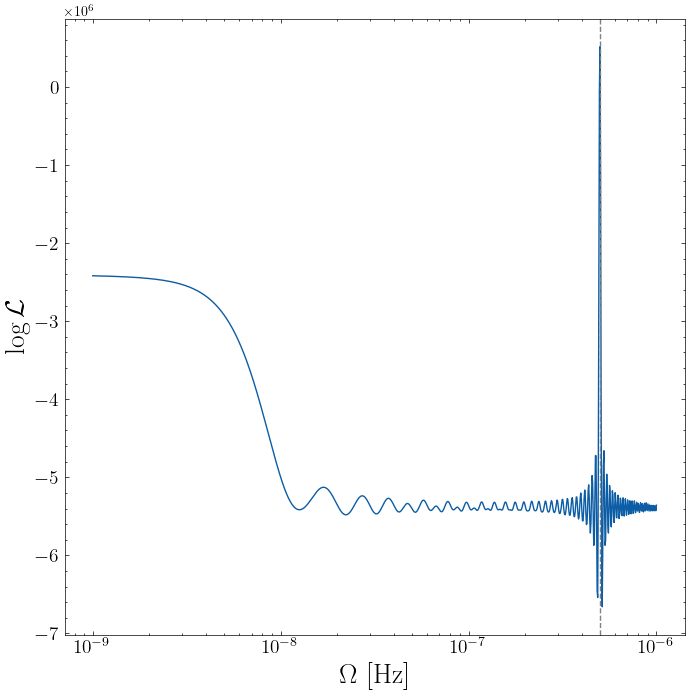

In [6]:
from plotting import plot_likelihood
plot_likelihood(parameter_range,likelihood_curves_earth_omega,r"$\Omega$ [Hz]",log_x_axes=True,injection=5e-7)

### Now lets do the same again, but iterate over all parameters:

In [38]:
#Set the measurement model again
measurement_model = 'pulsar' #Set the measurement model 


parameter_names = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw", "h"]
N = int(1e3)
parameter_ranges = [np.logspace(-9,-5,N),
                    np.linspace(-1.0,1.0,N),
                    np.linspace(2.0,3.0,N),
                    np.linspace(0.5,1.5,N),
                    np.linspace(0.5,1.5,N),
                    np.linspace(0.5,1.5,N),
                    np.logspace(-13,-11,N)
]



likelihood_data_dictionary={}


for j,parameter_name in enumerate(parameter_names):
    parameter_range = parameter_ranges[j]
    likelihood_data_array = np.zeros(len(parameter_range))     
      

    for i,p in enumerate(parameter_range):
        p = parameter_range[i]
        likelihood_data_array[i] = get_likelihood(data,parameter_name,p,P,PTA,measurement_model)

    likelihood_data_dictionary[parameter_name] = likelihood_data_array

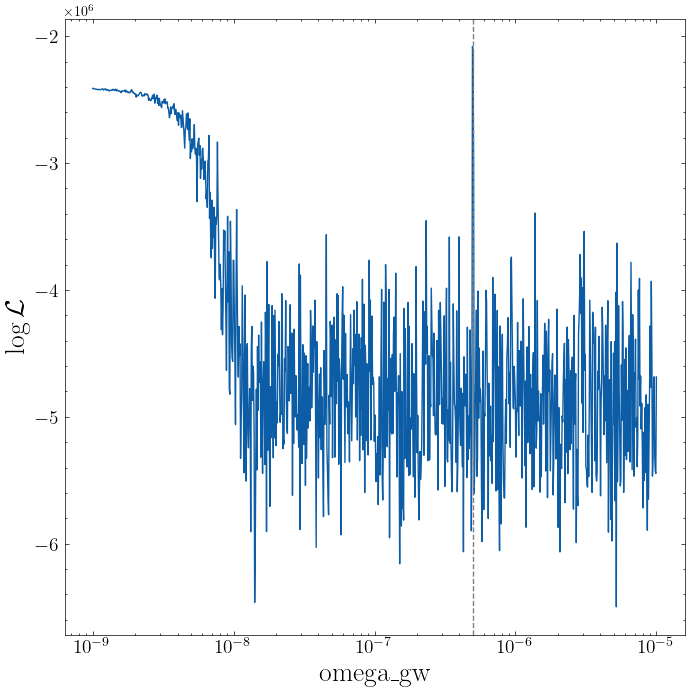

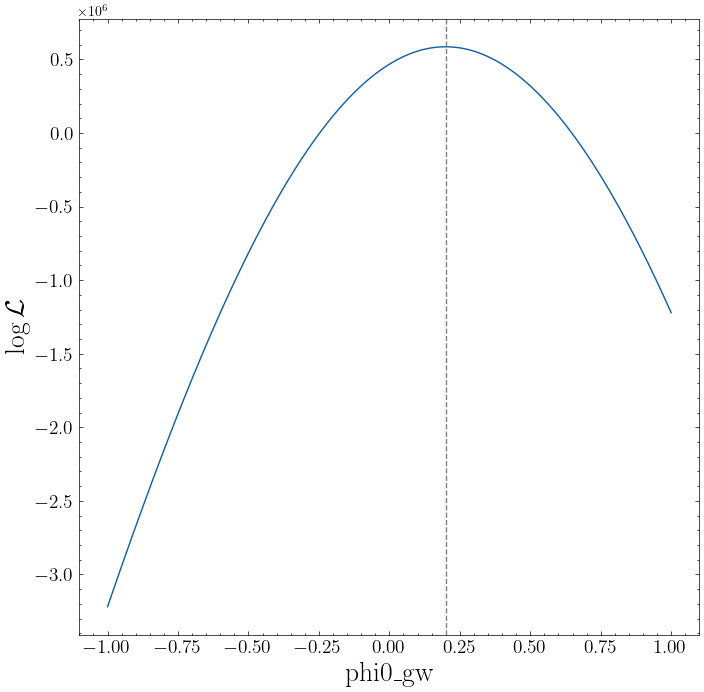

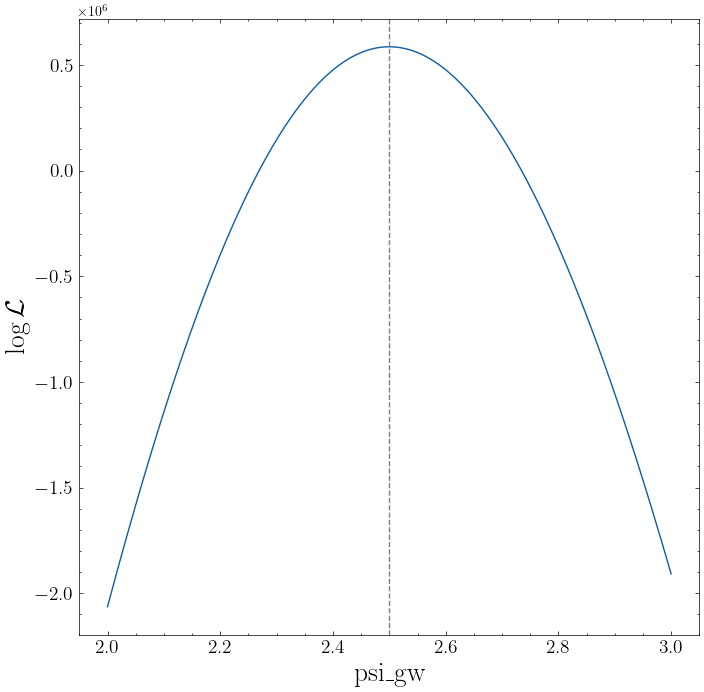

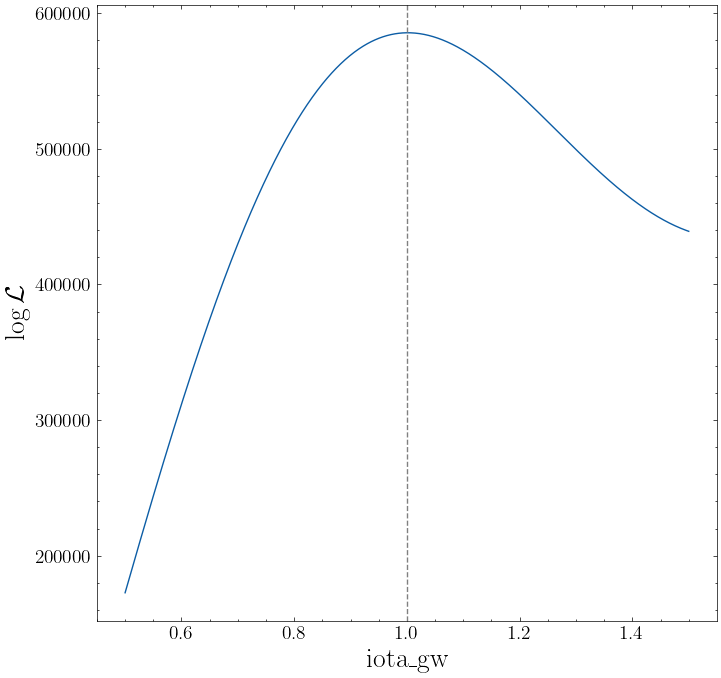

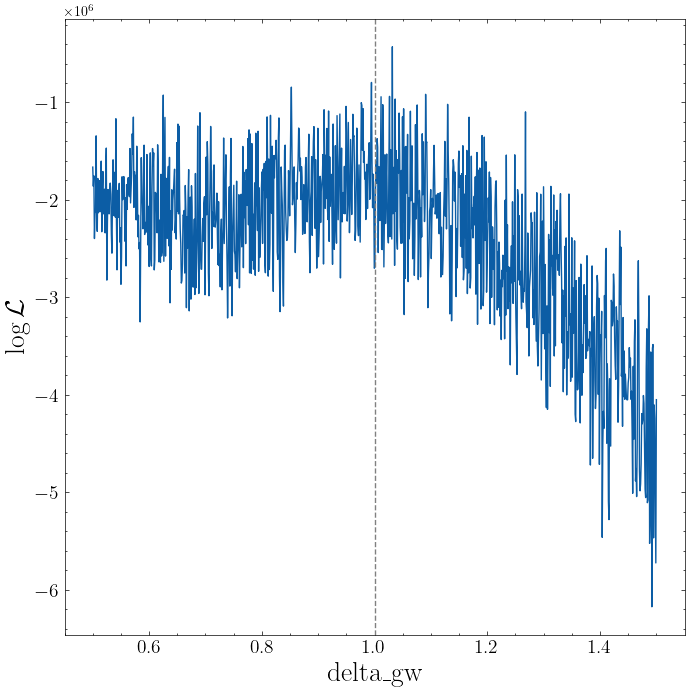

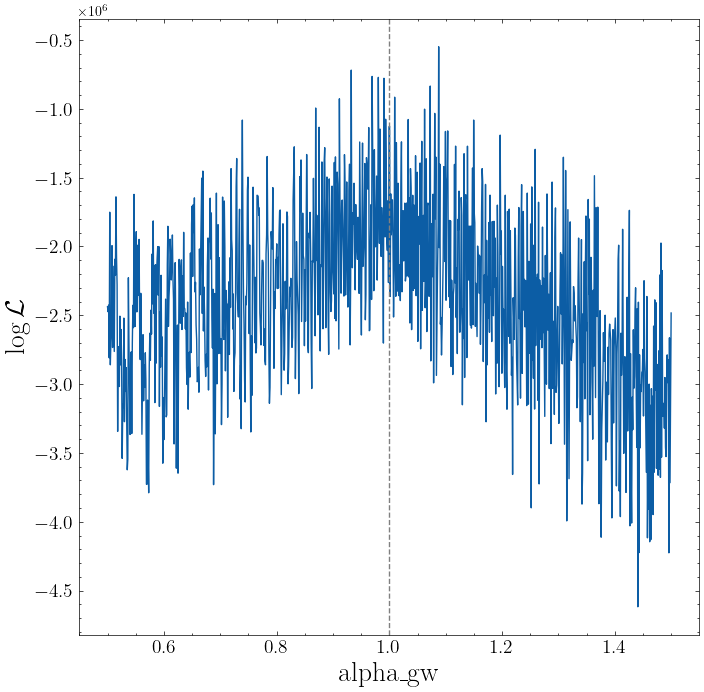

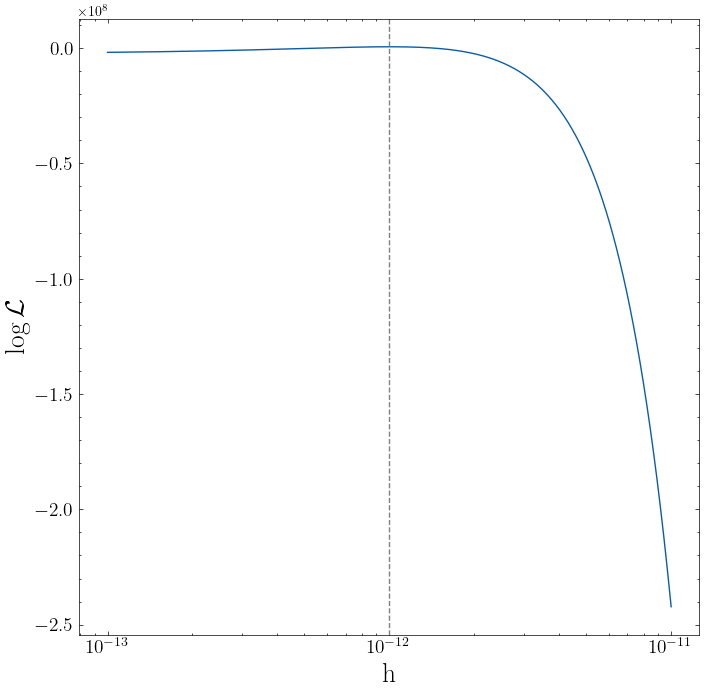

In [39]:
#And plot it all
log_axes = ["omega_gw","h"]
injection_values = [5e-7,0.20,2.50,1.0,1.0,1.0,1e-12]
for j,parameter_name in enumerate(parameter_names):
    if parameter_name in log_axes:
        log_x_axes=True
    else:
        log_x_axes=False
    plot_likelihood(parameter_ranges[j],likelihood_data_dictionary[parameter_name],parameter_name,log_x_axes=log_x_axes,injection=injection_values[j])


Most of the curves reamain smooth, but $\Omega$, $\delta$ and and $\alpha$ are super noisy


### What about with just the Earth terms?


Lets do the same again, but drop the pulsar terms

In [40]:
#Set the measurement model again
measurement_model = 'earth' #Set the measurement model 

parameter_names = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw", "h"]
N = int(1e3)
parameter_ranges = [np.logspace(-9,-5,N),
                    np.linspace(-1.0,1.0,N),
                    np.linspace(2.0,3.0,N),
                    np.linspace(0.5,1.5,N),
                    np.linspace(0.5,1.5,N),
                    np.linspace(0.5,1.5,N),
                    np.logspace(-13,-11,N)
]



likelihood_data_dictionary_earth={}


for j,parameter_name in enumerate(parameter_names):
    parameter_range = parameter_ranges[j]
    likelihood_data_array = np.zeros(len(parameter_range))     
      

    for i,p in enumerate(parameter_range):
        p = parameter_range[i]
        likelihood_data_array[i] = get_likelihood(data,parameter_name,p,P,PTA,measurement_model)

    likelihood_data_dictionary_earth[parameter_name] = likelihood_data_array

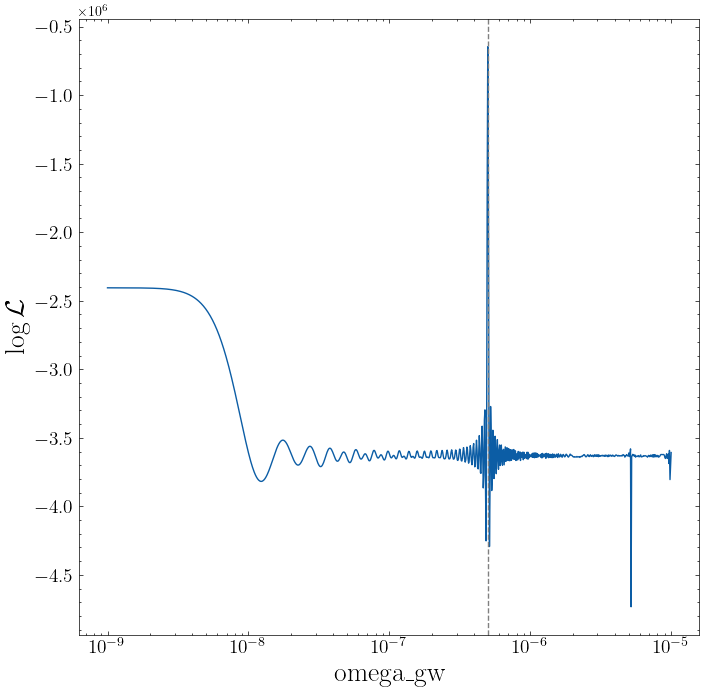

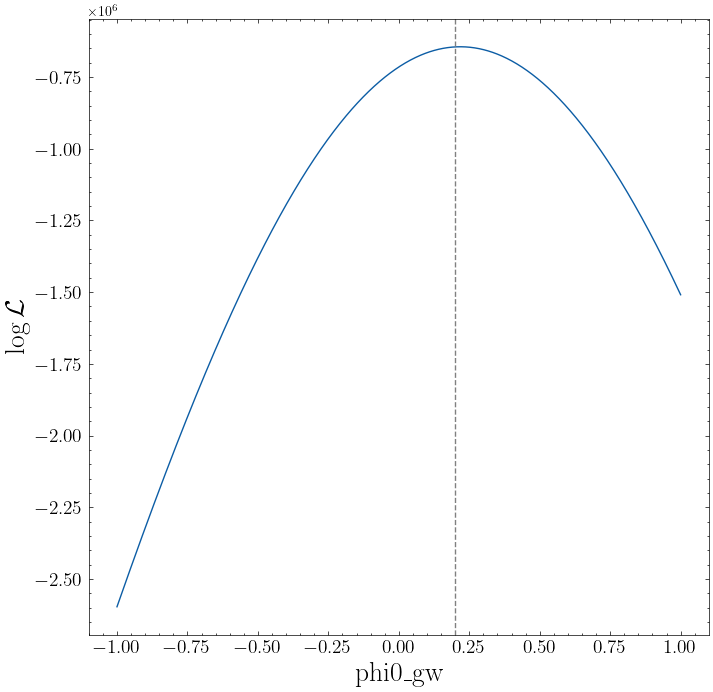

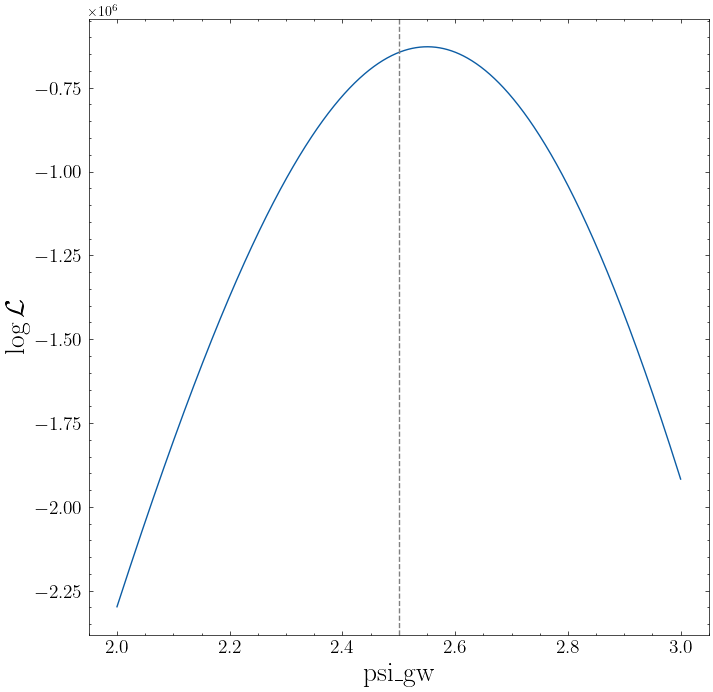

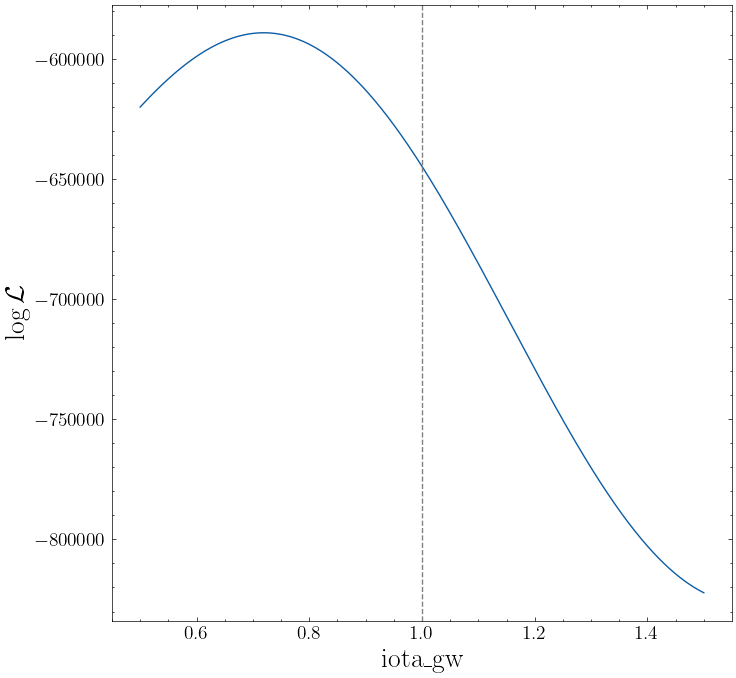

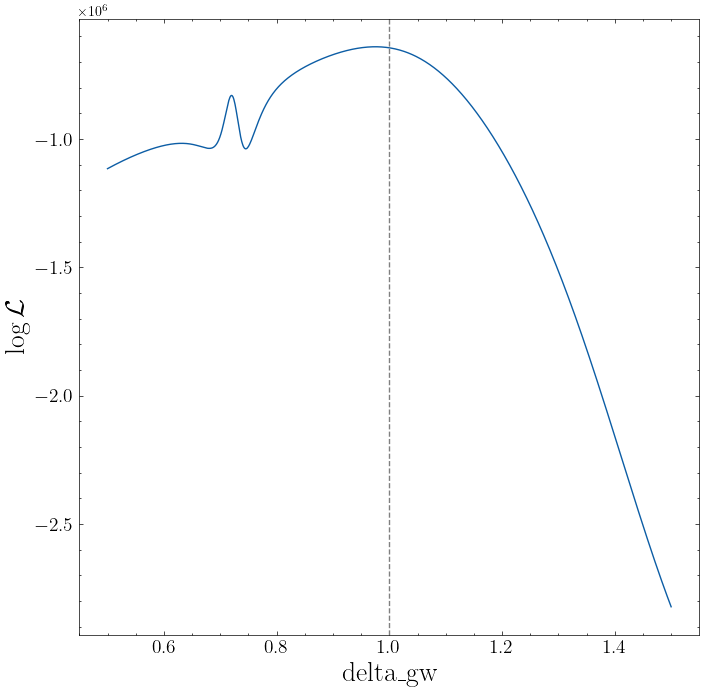

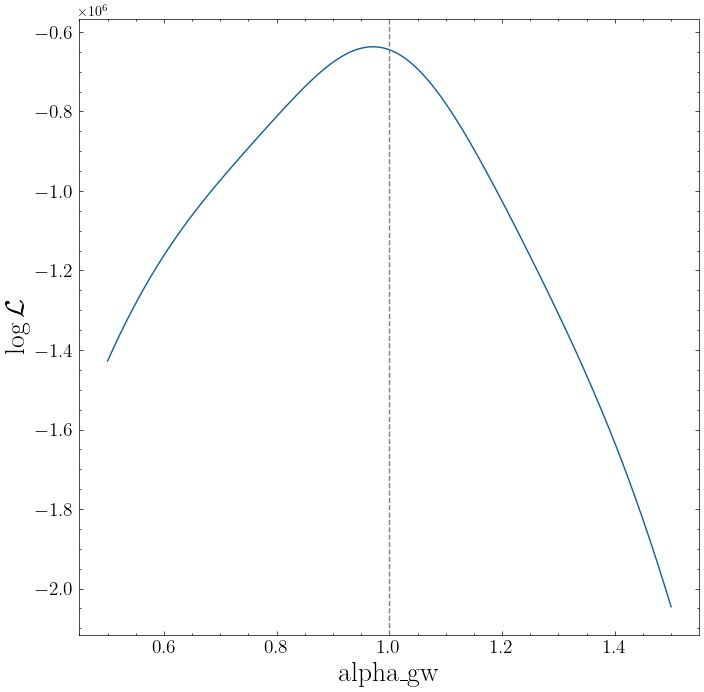

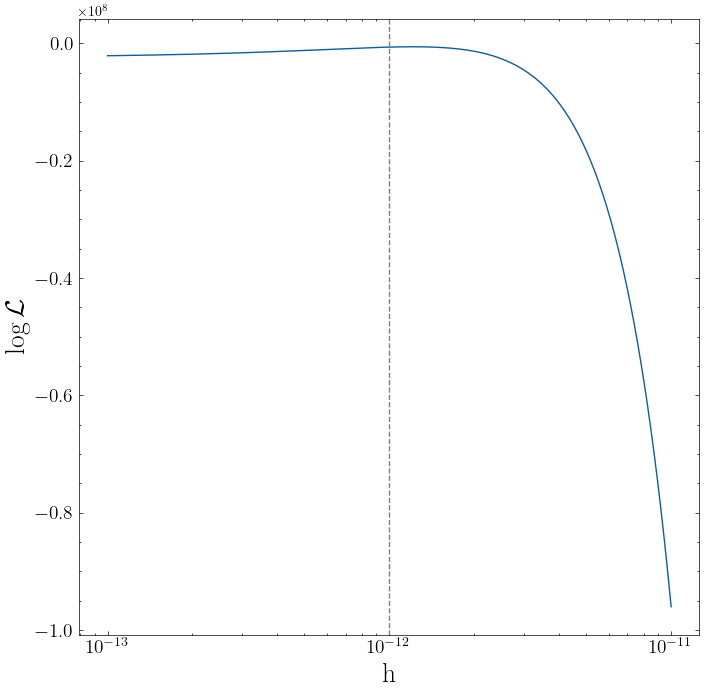

In [41]:
#And plot it all
log_axes = ["omega_gw","h"]
injection_values = [5e-7,0.20,2.50,1.0,1.0,1.0,1e-12]
for j,parameter_name in enumerate(parameter_names):
    if parameter_name in log_axes:
        log_x_axes=True
    else:
        log_x_axes=False
    plot_likelihood(parameter_ranges[j],likelihood_data_dictionary_earth[parameter_name],parameter_name,log_x_axes=log_x_axes,injection=injection_values[j])


# Appendix: Analytical form

In [42]:

def simple_model(omega,phi0,b,t): #b = (1+n \cdot q) d
    return np.cos(-omega*t + phi0) -  np.cos(-omega*t + phi0 + omega*b)


def log_likelihood(y,yc):
    return np.sum((yc - y)**2)

In [50]:
cadence = 7
TT = 10
dt = cadence * 24*3600 #from days to step_seconds
end_seconds= TT* 365*24*3600 #from years to second
t       = np.arange(0,end_seconds,dt)


omega = 5e-7
b = #(1+n \cdot q) d
yc = simple_model(omega,0.2,0.3,t)
y = simple_model(omega * 1.5,0.2,0.3,t)

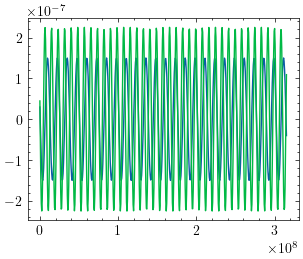

In [51]:
import matplotlib.pyplot as plt 

plt.plot(t,yc)
plt.plot(t,y)

In [45]:
omega_vals = np.arange(0.5,1.5,0.1)
likelihoods= np.zeros_like(omega_vals)
for i,omega in enumerate(omega_vals):
    y = simple_model(omega,0.2,0.3,t)
    likelihoods[i] = log_likelihood(y,yc)



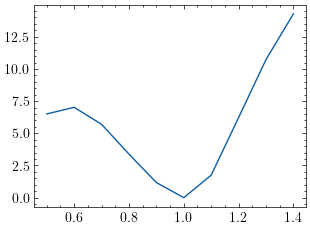

In [46]:
plt.plot(omega_vals,likelihoods)